To train this agent, click **Runtime** > **Run all**. Make sure you've enabled a free Tesla T4 GPU!

<div class="align-center">
<a href="https://github.com/openpipe/art"><img src="https://github.com/openpipe/art/raw/main/assets/ART_pill.png" height="50"></a>
<a href="https://discord.gg/zbBHRUpwf4"><img src="https://github.com/openpipe/art/raw/main/assets/Discord.png" height="50"></a>
<a href="https://art.openpipe.ai"><img src="https://github.com/openpipe/art/raw/main/assets/Documentation_pill.png" height="50"></a>

Questions? Join the Discord and ask away! For feature requests or to leave a star, visit our [GitHub](https://github.com/openpipe/art).

</div>

<a href="https://art.openpipe.ai/"><img src="https://github.com/openpipe/art/raw/main/assets/Header_separator.png" height="5"></a>

This notebook shows how to train a Qwen 2.5 3B model to play tic tac toe. It will demonstrate how to set up a multi-turn agent, how to train it, and how to evaluate it.

Completions and metrics will be logged to Weights & Biases.


### Installation


In [8]:
# Portions adapted from Unsloth Notebooks (https://github.com/unslothai/notebooks)
# Copyright (c) Unsloth contributors.
# License: GNU LGPL v3.0.
# Modifications by OpenPipe:
# - switched to uv
# - changed vllm/triton pinning logic
# - added protobuf pins
# See /licenses/LGPL-3.0.txt and /licenses/GPL-3.0.txt for full text.

%%capture
import os

if "COLAB_" not in "".join(os.environ.keys()):
    !uv pip install openpipe-art[backend]==0.4.11 --prerelease allow --no-cache-dir
else:
    try:
        import numpy

        get_numpy = f"numpy=={numpy.__version__}"
    except:
        get_numpy = "numpy"
    try:
        import subprocess

        is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except:
        is_t4 = False
    get_vllm, get_triton = (
        ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm", "triton")
    )
    !uv pip install --upgrade \
        openpipe-art[backend]==0.4.11 protobuf==5.29.5 {get_vllm} {get_numpy} --prerelease allow --no-cache-dir
    !uv pip install -qqq {get_triton}

### Environment Variables

Later on in the notebook, we'll be creating a model that can automatically logs metrics and chat completions to Weights & Biases. In order to do so, you'll need to provide your Weights & Biases API key as an environment variable.


In [9]:
import os

# Optional
WANDB_API_KEY = ""
if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY

### Agentic Environment

<a name="Environment"></a>

ART allows your agent to learn by interacting with its environment. In this example, we'll create an environment in which the agent can play tic tac toe.

Feel free to read as much or as little of this section's code as you'd like. The important thing to understand is that we're defining the rules of this agent's environment. In many cases, this will already be defined by the task you're trying to solve, but if you need to define a custom environment, this is how you do it.


In [10]:
import random
import xml.etree.ElementTree as ET
from typing import Literal, TypedDict, List
import gymnasium as gym
import numpy as np


class SudokuGame(TypedDict):
    board: List[List[int]]
    initial_board: List[List[int]]
    difficulty: Literal["easy", "medium", "hard"]


class PrimeSudokuEnv:
    """Prime Intellect style Sudoku Environment"""
    def __init__(self, difficulty: str = "easy"):
        self.difficulty = difficulty
        self.reset()

    def reset(self):
        if self.difficulty == "easy":
            self.board = [
                [5, 3, 0, 0, 7, 0, 0, 0, 0],
                [6, 0, 0, 1, 9, 5, 0, 0, 0],
                [0, 9, 8, 0, 0, 0, 0, 6, 0],
                [8, 0, 0, 0, 6, 0, 0, 0, 3],
                [4, 0, 0, 8, 0, 3, 0, 0, 1],
                [7, 0, 0, 0, 2, 0, 0, 0, 6],
                [0, 6, 0, 0, 0, 0, 2, 8, 0],
                [0, 0, 0, 4, 1, 9, 0, 0, 5],
                [0, 0, 0, 0, 8, 0, 0, 7, 9]
            ]
        else:
            self.board = [[0 for _ in range(9)] for _ in range(9)]

        self.initial_board = [row[:] for row in self.board]
        self.steps = 0
        self.solved = False
        return {"text": self._get_board_text()}

    def step(self, action):
        try:
            self._apply_move(action)
            self.steps += 1

            game_state = self._check_complete()
            if game_state == "solved":
                reward = 1.0
                self.solved = True
                done = True
            elif game_state == "invalid":
                reward = -0.5
                done = True
            else:
                reward = 0.1
                done = self.steps >= 81

        except ValueError as e:
            reward = -1.0
            done = False

        obs = {"text": self._get_board_text()}
        info = {"steps": self.steps, "solved": self.solved}
        return obs, reward, done, info

    def _apply_move(self, move_xml):
        try:
            root = ET.fromstring(move_xml)
            move_text = root.text.strip().upper()
        except Exception:
            raise ValueError("Invalid XML format")

        if '=' not in move_text:
            raise ValueError("Move must contain '='")

        cell, number_str = move_text.split('=')
        if len(cell) != 2:
            raise ValueError("Cell must be like 'A1'")

        row = ord(cell[0]) - 65
        col = int(cell[1]) - 1
        number = int(number_str)

        if row < 0 or row >= 9 or col < 0 or col >= 9:
            raise ValueError("Row or column out of bounds")
        if number < 1 or number > 9:
            raise ValueError("Number must be between 1-9")

        if not self._is_valid_move(row, col, number):
            raise ValueError(f"Invalid move: {move_text}")

        self.board[row][col] = number

    def _is_valid_move(self, row, col, number):
        if self.initial_board[row][col] != 0:
            return False

        if number in self.board[row]:
            return False

        if number in [self.board[i][col] for i in range(9)]:
            return False

        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        for i in range(box_row, box_row + 3):
            for j in range(box_col, box_col + 3):
                if self.board[i][j] == number:
                    return False

        return True

    def _check_complete(self):
        if any(0 in row for row in self.board):
            return "incomplete"

        for row in self.board:
            if sorted(row) != list(range(1, 10)):
                return "invalid"

        for col in range(9):
            column = [self.board[row][col] for row in range(9)]
            if sorted(column) != list(range(1, 10)):
                return "invalid"

        for box_row in range(0, 9, 3):
            for box_col in range(0, 9, 3):
                box = []
                for i in range(3):
                    for j in range(3):
                        box.append(self.board[box_row + i][box_col + j])
                if sorted(box) != list(range(1, 10)):
                    return "invalid"

        return "solved"

    def _get_board_text(self):
        board = self.board
        board_str = "   1 2 3   4 5 6   7 8 9\n"
        board_str += "  ┌───────┬───────┬───────┐\n"

        for i in range(9):
            if i in [3, 6]:
                board_str += "  ├───────┼───────┼───────┤\n"

            row_str = f"{chr(65+i)} │ "
            for j in range(9):
                if j in [3, 6]:
                    row_str += "│ "
                cell = board[i][j]
                row_str += f"{cell if cell != 0 else '.'} "

            row_str += "│\n"
            board_str += row_str

        board_str += "  └───────┴───────┴───────┘\n"
        return board_str

    def render(self):
        print(self._get_board_text())


def generate_sudoku_game(difficulty: str = "easy") -> SudokuGame:
    prime_env = PrimeSudokuEnv(difficulty)
    prime_env.reset()

    return {
        "board": [row[:] for row in prime_env.board],
        "initial_board": [row[:] for row in prime_env.initial_board],
        "difficulty": difficulty
    }


def render_sudoku_board(game: SudokuGame) -> str:
    board = game["board"]
    board_str = "   1 2 3   4 5 6   7 8 9\n"
    board_str += "  ┌───────┬───────┬───────┐\n"

    for i in range(9):
        if i in [3, 6]:
            board_str += "  ├───────┼───────┼───────┤\n"

        row_str = f"{chr(65+i)} │ "
        for j in range(9):
            if j in [3, 6]:
                row_str += "│ "
            cell = board[i][j]
            row_str += f"{cell if cell != 0 else '.'} "

        row_str += "│\n"
        board_str += row_str

    board_str += "  └───────┴───────┴───────┘\n"
    return board_str


def apply_agent_move(game: SudokuGame, move: str) -> None:
    prime_env = PrimeSudokuEnv(game["difficulty"])
    prime_env.board = [row[:] for row in game["board"]]
    prime_env.initial_board = [row[:] for row in game["initial_board"]]

    try:
        prime_env._apply_move(move)
        game["board"] = [row[:] for row in prime_env.board]
    except ValueError as e:
        raise ValueError(str(e))


def check_sudoku_complete(game: SudokuGame) -> Literal["solved", "invalid", "incomplete"]:
    prime_env = PrimeSudokuEnv(game["difficulty"])
    prime_env.board = [row[:] for row in game["board"]]
    prime_env.initial_board = [row[:] for row in game["initial_board"]]

    return prime_env._check_complete()

def is_valid_move(game: SudokuGame, row: int, col: int, number: int) -> bool:
    board = game["board"]
    initial = game["initial_board"]

    # Check if cell is fixed (from initial board)
    if initial[row][col] != 0:
        return False

    # Check if cell is already filled
    if board[row][col] != 0:
        return False

    # Check row
    if number in board[row]:
        return False

    # Check column
    if number in [board[i][col] for i in range(9)]:
        return False

    # Check 3x3 box
    box_row, box_col = 3 * (row // 3), 3 * (col // 3)
    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if board[i][j] == number:
                return False

    return True

### Creating a Model

Now that we've defined the rules of our environment, we can create a model that will learn to play 2048. We'll use a Qwen 2.5 3B model for this example. The `name` parameter will be associated with a wandb run, and the `base_model` parameter is the model that we'll be training a LoRA on top of.


In [11]:
from dotenv import load_dotenv

import art
from art.local import LocalBackend

load_dotenv()

random.seed(42)

backend = LocalBackend(path="./.art")

### Creating a Model

Now that we've defined the rules of our environment, we can create a model that will learn to play tic tac toe. We'll use a Qwen 2.5 3B model for this example. The `name` parameter will be associated with a wandb run, and the `base_model` parameter is the model that we'll be training a LoRA on top of.


In [12]:
import os

model = art.TrainableModel(
    name="001-sudoku-script",
    project="sudoku-solver",
    base_model="Qwen/Qwen2.5-3B-Instruct",
)
await model.register(backend)

### Defining a Rollout

<a name="Rollout"></a>

A rollout is a single episode of an agent performing its task. It generates one or more trajectories, which are lists of messages and choices.

In this example, the rollout function generates a game of tic tac toe, and the agent plays it until the game is finished. It then returns a trajectory which contains all the `system` and `user` messages presented to the agent, as well as all the `choices` that the agent made.

When the game is finished the `reward` for the agent's performance is calculated based on whether the agent won, lost, drew, or errored, which is then assigned to the trajectory.

This rollout function will be called many times in parallel during each step of the training loop.


In [13]:
import math
import openai
import weave
from openai import AsyncOpenAI
from pydantic import BaseModel
import art

if os.getenv("WANDB_API_KEY", ""):
    print("initializing weave")
    weave.init(model.project, settings={"print_call_link": False})


class SudokuScenario(BaseModel):
    step: int


def get_valid_moves_hint(game: SudokuGame) -> str:
    """Generate hints about valid moves"""
    board = game["board"]
    initial = game["initial_board"]
    valid_moves = []

    for i in range(9):
        for j in range(9):
            if board[i][j] == 0 and initial[i][j] == 0:  # Empty and not fixed
                cell_name = f"{chr(65+i)}{j+1}"
                # Find possible numbers for this cell
                possible_numbers = []
                for num in range(1, 10):
                    if is_valid_move(game, i, j, num):
                        possible_numbers.append(str(num))
                if possible_numbers:
                    valid_moves.append(f"{cell_name}=[{','.join(possible_numbers)}]")

    if valid_moves:
        return f"Possible moves: {', '.join(valid_moves[:5])}..."  # Show first 5
    return "No valid moves found"


@weave.op
@art.retry(exceptions=(openai.LengthFinishReasonError,))
async def rollout(model: art.Model, scenario: SudokuScenario) -> art.Trajectory:
    game = generate_sudoku_game()

    trajectory = art.Trajectory(
        messages_and_choices=[
            {
                "role": "system",
                "content": """You are a Sudoku solver. CRITICAL RULES:
1. You can ONLY place numbers in EMPTY cells (shown as . or 0)
2. You CANNOT change the initial numbers (already filled cells)
3. Numbers must be 1-9
4. No repeats in rows, columns, or 3x3 boxes
5. Return ONLY: <move>CELL=NUMBER</move> where CELL is like A1, B2, etc.

VALID MOVE EXAMPLES:
- <move>A3=4</move>  (if A3 is empty)
- <move>B7=8</move>  (if B7 is empty)
- <move>C1=2</move>  (if C1 is empty)

INVALID MOVE EXAMPLES:
- <move>A1=3</move>  (A1 already has 5 - CANNOT CHANGE)
- <move>B2=9</move>  (B2 already has 9 - CANNOT CHANGE)
- <move>A1=5</move>  (A1 already has 5 - REDUNDANT)""",
            }
        ],
        metadata={
            "notebook-id": "sudoku-solver",
            "step": scenario.step,
        },
        reward=0,
    )

    move_number = 0
    max_moves = 20  # Reduced to focus on learning valid moves

    while move_number < max_moves and check_sudoku_complete(game) == "incomplete":
        # Add hints about valid moves
        valid_moves_hint = get_valid_moves_hint(game)
        board_with_hint = f"{render_sudoku_board(game)}\n\n{valid_moves_hint}"

        trajectory.messages_and_choices.append(
            {"role": "user", "content": board_with_hint}
        )

        messages = trajectory.messages()

        try:
            client = AsyncOpenAI(
                base_url=model.inference_base_url,
                api_key=model.inference_api_key,
            )

            chat_completion = await client.chat.completions.create(
                model=model.get_inference_name(),
                messages=messages,
                max_completion_tokens=50,  # Reduced for shorter responses
                temperature=0.1,  # Lower temperature for more consistent output
            )
        except openai.LengthFinishReasonError as e:
            raise e
        except Exception as e:
            print("caught exception generating chat completion")
            print(e)
            global failing_trajectory
            failing_trajectory = trajectory
            raise e

        choice = chat_completion.choices[0]
        content = choice.message.content
        assert isinstance(content, str)
        trajectory.messages_and_choices.append(choice)

        try:
            apply_agent_move(game, content)
            # Reward for valid moves
            trajectory.reward += 0.05  # Small reward for each valid move
            move_number += 1

            # Check if we're making progress
            empty_cells = sum(1 for row in game["board"] for cell in row if cell == 0)
            trajectory.metrics["empty_cells"] = empty_cells

        except ValueError as e:
            trajectory.reward = -0.5  # Reduced penalty
            trajectory.metrics["invalid_moves"] = trajectory.metrics.get("invalid_moves", 0) + 1
            break

        if check_sudoku_complete(game) != "incomplete":
            break

    winner = check_sudoku_complete(game)

    if winner == "solved":
        trajectory.reward = 1.0
        trajectory.metrics["solved"] = 1
    elif winner == "invalid":
        trajectory.reward = 0
        trajectory.metrics["solved"] = 0
    elif winner == "incomplete":
        # Reward based on progress
        initial_empty = sum(1 for row in game["initial_board"] for cell in row if cell == 0)
        current_empty = sum(1 for row in game["board"] for cell in row if cell == 0)
        progress = (initial_empty - current_empty) / initial_empty
        trajectory.reward = 0.3 + (progress * 0.7)  # 0.3 to 1.0 based on progress
        trajectory.metrics["solved"] = 0.5

    trajectory.metrics["valid_moves"] = move_number
    trajectory.metrics["total_moves"] = move_number + trajectory.metrics.get("invalid_moves", 0)

    return trajectory

<a name="Loop"></a>

### Training Loop

The training loop is where the magic happens. For each of the 100 steps defined below, the rollout function will be called 200 times in parallel. This means that 200 games will be played at once. Each game will produce a trajectory, which will be used to update the model.

The `gather` step will wait for all of the trajectories to be generated, then it will delete all but the most recent checkpoint and train the model on the new trajectories.

Inference will be blocked until the training is complete.


In [14]:
TRAINING_STEPS = 4  # Increased from 2
ROLLOUTS_PER_STEP = 24  # Reduced from 48 for better quality
LEARNING_RATE = 3e-5  # Slightly lower

for i in range(await model.get_step(), TRAINING_STEPS):
    train_groups = await art.gather_trajectory_groups(
        (
            art.TrajectoryGroup(
                rollout(model, SudokuScenario(step=i))
                for _ in range(ROLLOUTS_PER_STEP)
            )
            for _ in range(1)
        ),
        pbar_desc="gather",
    )
    await model.delete_checkpoints()
    await model.train(train_groups, config=art.TrainConfig(learning_rate=LEARNING_RATE))

gather:   0%|          | 0/24 [00:00<?, ?it/s]

"./.art/sudoku-solver/models/001-sudoku-script/history.jsonl" not found


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Skipping tuning as there is no suitable data. This can happen when all the trajectories in the same group have the same reward and thus no advantage to train on.
Advanced step from 0 to 1 (no training occurred)


gather:   0%|          | 0/24 [00:00<?, ?it/s]

No "val/reward" metric found in history
Skipping tuning as there is no suitable data. This can happen when all the trajectories in the same group have the same reward and thus no advantage to train on.
Advanced step from 1 to 2 (no training occurred)


gather:   0%|          | 0/24 [00:00<?, ?it/s]

No "val/reward" metric found in history
Skipping tuning as there is no suitable data. This can happen when all the trajectories in the same group have the same reward and thus no advantage to train on.
Advanced step from 2 to 3 (no training occurred)


gather:   0%|          | 0/24 [00:00<?, ?it/s]

No "val/reward" metric found in history
Skipping tuning as there is no suitable data. This can happen when all the trajectories in the same group have the same reward and thus no advantage to train on.
Advanced step from 3 to 4 (no training occurred)


### Using the Model

Just like that, you've trained an agent to play tic tac toe! Now it's time to use your model outside of ART, in the wild! The easiest way to do that is to load it from disk, where it was saved after each training step, and either run inference on it locally or upload it to a central hub like HuggingFace.

Check out the code below for small demo of the model you just trained playing tic tac toe!



Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-4' coro=<LocalBackend._monitor_openai_server() done, defined at /usr/local/lib/python3.12/dist-packages/art/local/backend.py:287> exception=ClientConnectorError(ConnectionKey(host='0.0.0.0', port=8000, is_ssl=False, ssl=True, proxy=None, proxy_auth=None, proxy_headers_hash=None), ConnectionRefusedError(111, "Connect call failed ('0.0.0.0', 8000)"))>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/aiohttp/connector.py", line 1268, in _wrap_create_connection
    sock = await aiohappyeyeballs.start_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/aiohappyeyeballs/impl.py", line 122, in start_connection
    raise first_exception
  File "/usr/local/lib/python3.12/dist-packages/aiohappyeyeballs/impl.py", line 73, in start_connection
    sock = await _connect_sock(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local

loading model from .art/sudoku-solver/models/001-sudoku-script/checkpoints/0004

==((====))==  Unsloth 2025.8.6: Fast Qwen2 patching. Transformers: 4.53.2. vLLM: 0.9.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device does not support bfloat16. Will change to float16.
Unsloth 2025.8.6 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



GAME 1
Raw output: A3=2
A4=6
A6=4
A6=8
A7=9
A8=1
✅ Valid move 1: <move>A3=2</move>
Updated board:
   1 2 3   4 5 6   7 8 9
  ┌───────┬───────┬───────┐
A │ 5 3 2 │ . 7 . │ . . . │
B │ 6 . . │ 1 9 5 │ . . . │
C │ . 9 8 │ . . . │ . 6 . │
  ├───────┼───────┼───────┤
D │ 8 . . │ . 6 . │ . . 3 │
E │ 4 . . │ 8 . 3 │ . . 1 │
F │ 7 . . │ . 2 . │ . . 6 │
  ├───────┼───────┼───────┤
G │ . 6 . │ . . . │ 2 8 . │
H │ . . . │ 4 1 9 │ . . 5 │
I │ . . . │ . 8 . │ . 7 9 │
  └───────┴───────┴───────┘

Raw output: <move>A3=2</move>
❌ Invalid move: <move>A3=2</move>
Reason: Invalid move: A3=2
Raw output: <move>A4=6</move>
✅ Valid move 2: <move>A4=6</move>
Updated board:
   1 2 3   4 5 6   7 8 9
  ┌───────┬───────┬───────┐
A │ 5 3 2 │ 6 7 . │ . . . │
B │ 6 . . │ 1 9 5 │ . . . │
C │ . 9 8 │ . . . │ . 6 . │
  ├───────┼───────┼───────┤
D │ 8 . . │ . 6 . │ . . 3 │
E │ 4 . . │ 8 . 3 │ . . 1 │
F │ 7 . . │ . 2 . │ . . 6 │
  ├───────┼───────┼───────┤
G │ . 6 . │ . . . │ 2 8 . │
H │ . . . │ 4 1 9 │ . . 5 │
I │ . . 

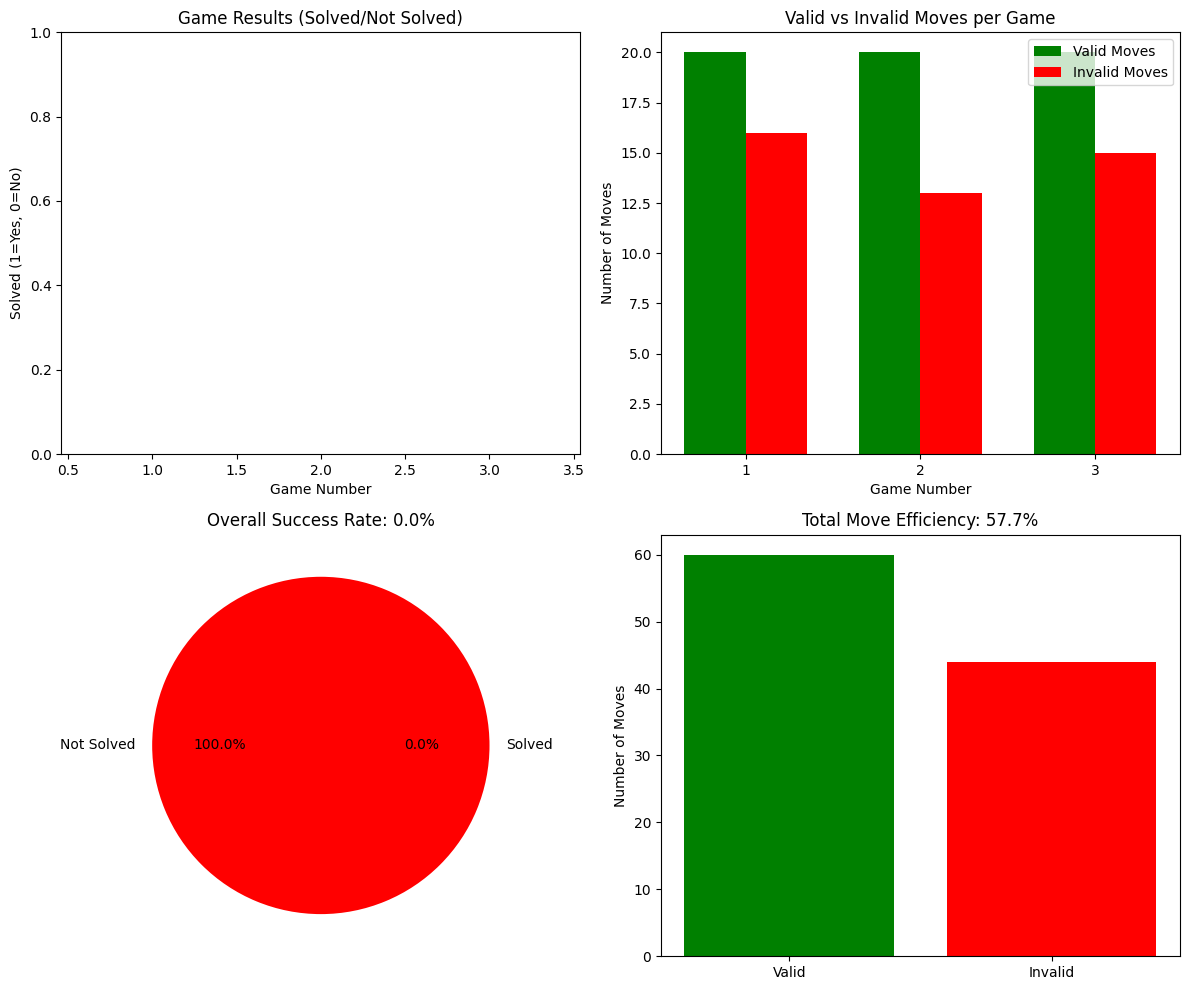


Summary Statistics:
Games played: 3
Games solved: 0/3 (0.0%)
Total valid moves: 60
Total invalid moves: 44
Move efficiency: 57.7%
Average valid moves per game: 20.0
Average invalid moves per game: 14.7


In [15]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

lora_model_path = (
    f".art/{model.project}/models/{model.name}/checkpoints/{await model.get_step():04d}"
)

if Path(lora_model_path).exists():
    import torch
    from unsloth import FastLanguageModel

    print(f"loading model from {lora_model_path}\n")

    peft_model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=lora_model_path,
        max_seq_length=32768,
        dtype=torch.bfloat16,
        load_in_4bit=True,
    )
    FastLanguageModel.for_inference(peft_model)

    # Test multiple games
    num_games = 3
    results = []

    for game_num in range(num_games):
        print(f"\n{'='*50}")
        print(f"GAME {game_num + 1}")
        print(f"{'='*50}")

        game = generate_sudoku_game()
        move_number = 0
        max_moves = 20
        valid_moves_count = 0
        invalid_moves_count = 0

        messages = [
            {
                "role": "system",
                "content": """You are a Sudoku solver. Return ONLY: <move>CELL=NUMBER</move>
CRITICAL: Only place numbers in EMPTY cells (shown as .). Never change existing numbers.""",
            },
        ]

        while move_number < max_moves and check_sudoku_complete(game) == "incomplete":
            # Get valid moves hint
            valid_moves_hint = get_valid_moves_hint(game)
            board_with_hint = f"{render_sudoku_board(game)}\n\n{valid_moves_hint}"

            # Keep context short
            if len(messages) > 4:
                messages = [messages[0]] + messages[-2:]

            messages.append({"role": "user", "content": board_with_hint})

            inputs = tokenizer.apply_chat_template(
                messages,
                return_tensors="pt",
                add_generation_prompt=True,
                truncation=True,
                max_length=4000,
            ).to("cuda")

            content = ""

            def get_completion() -> str:
                with torch.no_grad():
                    outputs = peft_model.generate(
                        input_ids=inputs,
                        max_new_tokens=30,
                        do_sample=True,
                        temperature=0.1,  # Very low temperature for consistency
                        top_p=0.9,
                        pad_token_id=tokenizer.eos_token_id,
                    )
                    return tokenizer.decode(
                        outputs[0][inputs.shape[1]:],
                        skip_special_tokens=True
                    ).strip()

            try:
                content = get_completion()
                print(f"Raw output: {content}")
            except Exception as e:
                print("Error:", e)
                break

            # Extract XML move
            import re
            xml_match = re.search(r'<move>([^<]+)</move>', content)
            if xml_match:
                content = f"<move>{xml_match.group(1)}</move>"
            else:
                # Try to find A1=5 pattern
                move_match = re.search(r'([A-I][1-9]=[1-9])', content)
                if move_match:
                    content = f"<move>{move_match.group(1)}</move>"

            messages.append({"role": "assistant", "content": content})

            try:
                apply_agent_move(game, content)
                valid_moves_count += 1
                move_number += 1

                print(f"✅ Valid move {move_number}: {content}")
                print(f"Updated board:\n{render_sudoku_board(game)}")

            except ValueError as e:
                invalid_moves_count += 1
                print(f"❌ Invalid move: {content}")
                print(f"Reason: {e}")
                # Remove invalid move from history
                messages.pop()
                continue

            game_state = check_sudoku_complete(game)
            if game_state == "solved":
                print("🎉 SOLVED!")
                break
            elif game_state == "invalid":
                print("❌ INVALID SOLUTION")
                break

        # Record results
        final_state = check_sudoku_complete(game)
        results.append({
            'game': game_num + 1,
            'final_state': final_state,
            'valid_moves': valid_moves_count,
            'invalid_moves': invalid_moves_count,
            'total_moves': move_number,
            'solved': final_state == "solved"
        })

        print(f"\nGame {game_num + 1} Summary:")
        print(f"Final state: {final_state}")
        print(f"Valid moves: {valid_moves_count}")
        print(f"Invalid moves: {invalid_moves_count}")
        print(f"Total moves: {move_number}")
        print(f"Solved: {'Yes' if final_state == 'solved' else 'No'}")

    # Create visualization
    print(f"\n{'='*50}")
    print("PERFORMANCE SUMMARY")
    print(f"{'='*50}")

    # Bar chart for results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    # Game results
    game_nums = [r['game'] for r in results]
    solved = [1 if r['solved'] else 0 for r in results]
    valid_moves = [r['valid_moves'] for r in results]
    invalid_moves = [r['invalid_moves'] for r in results]

    ax1.bar(game_nums, solved, color=['red' if not s else 'green' for s in solved])
    ax1.set_title('Game Results (Solved/Not Solved)')
    ax1.set_xlabel('Game Number')
    ax1.set_ylabel('Solved (1=Yes, 0=No)')
    ax1.set_ylim(0, 1)

    # Valid vs Invalid moves
    x = np.arange(len(game_nums))
    width = 0.35
    ax2.bar(x - width/2, valid_moves, width, label='Valid Moves', color='green')
    ax2.bar(x + width/2, invalid_moves, width, label='Invalid Moves', color='red')
    ax2.set_title('Valid vs Invalid Moves per Game')
    ax2.set_xlabel('Game Number')
    ax2.set_ylabel('Number of Moves')
    ax2.set_xticks(x)
    ax2.set_xticklabels(game_nums)
    ax2.legend()

    # Success rate
    success_rate = (sum(solved) / len(solved)) * 100
    ax3.pie([success_rate, 100-success_rate],
            labels=['Solved', 'Not Solved'],
            autopct='%1.1f%%',
            colors=['green', 'red'])
    ax3.set_title(f'Overall Success Rate: {success_rate:.1f}%')

    # Move efficiency
    total_valid = sum(valid_moves)
    total_invalid = sum(invalid_moves)
    total_moves = total_valid + total_invalid
    efficiency = (total_valid / total_moves * 100) if total_moves > 0 else 0

    ax4.bar(['Valid', 'Invalid'], [total_valid, total_invalid],
            color=['green', 'red'])
    ax4.set_title(f'Total Move Efficiency: {efficiency:.1f}%')
    ax4.set_ylabel('Number of Moves')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"Games played: {num_games}")
    print(f"Games solved: {sum(solved)}/{num_games} ({success_rate:.1f}%)")
    print(f"Total valid moves: {total_valid}")
    print(f"Total invalid moves: {total_invalid}")
    print(f"Move efficiency: {efficiency:.1f}%")
    print(f"Average valid moves per game: {total_valid/num_games:.1f}")
    print(f"Average invalid moves per game: {total_invalid/num_games:.1f}")

<div class="align-center">
<a href="https://github.com/openpipe/art"><img src="https://github.com/openpipe/art/raw/main/assets/ART_pill.png" height="50"></a>
<a href="https://discord.gg/zbBHRUpwf4"><img src="https://github.com/openpipe/art/raw/main/assets/Discord.png" height="50"></a>
<a href="https://openpipe.ai/blog/art-e-mail-agent"><img src="https://github.com/openpipe/art/raw/main/assets/ART_E_pill.png" height="50"></a>

Questions? Join the Discord and ask away! For feature requests or to leave a star, visit our [Github](https://github.com/openpipe/art).

</div>
